In [ ]:
import Pkg

Pkg.add("Distributions")
Pkg.add("CairoMakie")
Pkg.add("LightGraphs")
Pkg.add("LinearAlgebra")

In [1]:
using Random
using Distributions
using CairoMakie
using LightGraphs
using LinearAlgebra

## Generating Random Points

In [2]:
points = rand(Xoshiro(420), Float64, (2, 200));

## Find the centermost point

In [3]:
function find_center(points::Matrix{Float64})    
    # Compute the mean of the points along each dimension
    mean_point = mean(points, dims=2)

    # Compute distances from the mean point to every other point
    distances = [norm(points[:, i] - mean_point) for i in 1:size(points, 2)]

    # Find the index of the closest point
    center_index = argmin(distances)

    # Return the center point and its index
    return points[:, center_index], center_index
end;

In [4]:
_, center_idx = find_center(points)

([0.5023869881832056, 0.4785613772132926], 12)

## Create a graph based on the random points

In [5]:
function random_geometric_graph(points::Matrix{Float64}, r::Float64)
    # Get the number of points (columns in the matrix)
    n = size(points, 2)  

    # Initialize the graph
    g = SimpleGraph(n)  # Create an empty graph with n nodes

    # Add edges based on distance threshold
    for i in 1:n
        for j in i+1:n
            if norm(points[:, i] - points[:, j]) <= r
                add_edge!(g, i, j)
            end
        end
    end

    return g
end;

In [6]:
G = random_geometric_graph(points, 0.125);

## Visualize the graph

In [7]:
function visualize_graph(g::SimpleGraph, points::Matrix{Float64}, center_idx::Int64; color_map::Symbol=:lajolla)
    dijkstra_result = dijkstra_shortest_paths(G, center_idx)
    distances = dijkstra_result.dists

    # Get the range of distances to normalize colors
    min_dist = minimum(distances)
    max_dist = maximum(distances)

    # Normalize distances to [0, 1] for color mapping
    normalized_distances = (distances .- min_dist) ./ (max_dist - min_dist);

    # Generate a colormap based on distances
    colormap = cgrad(color_map, length(normalized_distances))  # Viridis is a good color map for this

    # Assign colors to nodes
    node_colors = [colormap[round(Int, d * (length(colormap) - 1)) + 1] for d in normalized_distances]

    # Extract edges for plotting
    edgs = collect(edges(G))
    x_coords = points[1, :]
    y_coords = points[2, :]

    # Prepare edge coordinates for plotting
    edge_x = []
    edge_y = []
    for edge in edgs
        src = edge.src  # Source node
        dst = edge.dst  # Destination node
        push!(edge_x, [x_coords[src], x_coords[dst], NaN])
        push!(edge_y, [y_coords[src], y_coords[dst], NaN])
    end

    # Flatten edge coordinates for plotting
    flat_edge_x = vcat(edge_x...)
    flat_edge_y = vcat(edge_y...)

    fig = Figure()
    ax = Axis(fig[1, 1], title="Random Graph", aspect=DataAspect())

    # Plot edges
    lines!(ax, flat_edge_x, flat_edge_y, color=:gray, linewidth=0.5)

    # Plot nodes
    scatter!(ax, x_coords, y_coords, color=node_colors, markersize=15)

    return fig
end;

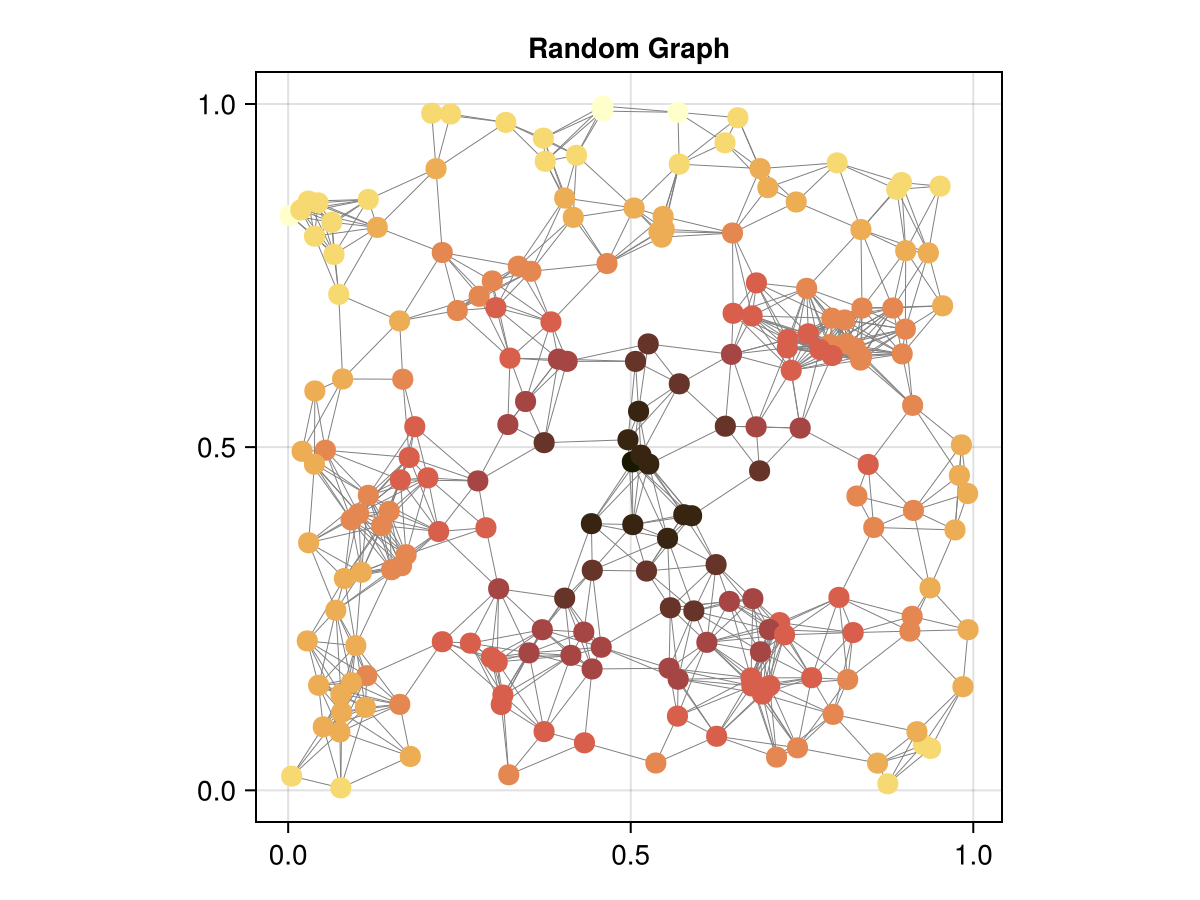

In [9]:
fig = visualize_graph(G, points, center_idx)
display(fig)

save_path = joinpath(@__DIR__, "../fig/Graph.png")
save(save_path, fig);  # Save as PNG